## Using FAST.AI for NLP

Exploring the MIMIC III data set medical notes.

Tried working with the full dataset, but almost every training step takes many hours (~13 for initial training), predicted 14+ per epoch for fine tuning.

Instead will try to work with just 10% sample... Not sure that will work though

A few notes:
* See https://docs.fast.ai/text.transform.html#Tokenizer for details on what various artificial tokens (e.g xxup, xxmaj, etc.) mean
* To view nicely formatted documentation on the fastai library, run commands like: ` doc(learn.lr_find)`

### To Do:
* need to evalate how changing the learning rate would alter training time
* need to evalate how changing the learning rate would alter accuracy

In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc

If you want to verify that Torch can find and use your GPU, run the following code:

```python
import torch

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
```

These next cells can be used to get an idea of the speed up provided by a GPU for some operations (from https://course.fast.ai/gpu_tutorial.html)
```python
import torch
t_cpu = torch.rand(500,500,500)
%timeit t_cpu @ t_cpu
```

```python
t_gpu = torch.rand(500,500,500).cuda()
%timeit t_gpu @ t_gpu
```

In [2]:
# pandas doesn't understand ~, so provide full path
base_path = Path('/home/seth/mimic')

# files used during processing - all aggregated here
notes_file = base_path/'noteevents.pickle'
lm_file = 'mimic_lm.pickle' # actual file is at base_path/lm_file but due to fastai function, have to pass file name separately
init_model_file = base_path/'mimic_fit_head'
cycles_file = base_path/'num_iterations.pickle'
lm_base_file = 'mimic_lm_fine_tuned_'
enc_file = 'mimic_fine_tuned_enc'
class_file = 'mimic_cl.pickle'

In [23]:
# if this doesn't free memory, can restart Python kernel.
# if that still doesn't work, try OS items mentioned here: https://docs.fast.ai/dev/gpu.html
def release_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [3]:
# run this to see what has already been imported
#whos

### Set Random Number seed for repeatability; set Batch Size to control GPU memory

See **"Performance notes"** section below for how setting batch size impacts GPU memory

In [4]:
seed = 42
# previously used 48; worked fine but never seemed to use even half of GPU memory; 64 still on the small side
bs=48

While parsing a CSV and converting to a dataframe is pretty fast, loading a pickle file is much faster.

For load time and size comparison:
* `NOTEEVENTS.csv` is ~ 3.8GB in size
  ```
  CPU times: user 51.2 s, sys: 17.6 s, total: 1min 8s
  Wall time: 1min 47s
  ```
* `noteevents.pickle` is ~ 3.7 GB in size
  ```
  CPU times: user 2.28 s, sys: 3.98 s, total: 6.26 s
  Wall time: 6.26 s
  ```

In [5]:
%%time

orig_df = pd.DataFrame()
if os.path.isfile(notes_file):
    print('Loading noteevnt pickle file')
    orig_df = pd.read_pickle(notes_file)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(base_path/'NOTEEVENTS.csv', low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_file)

Loading noteevnt pickle file
CPU times: user 1.19 s, sys: 1.27 s, total: 2.46 s
Wall time: 2.46 s


Due to data set size and performance reasons, working with a 10% sample. Use same random see to get same results from subsequent runs.

In [6]:
df = orig_df.sample(frac=0.1, random_state=seed)

In [7]:
# if you want to free up some memory
# orig_df = None
# del orig_df
gc.collect()

51

In [8]:
from pympler import asizeof
print('df:', asizeof.asizeof(df))
#print('orig_df:', asizeof.asizeof(orig_df))
#print('data_lm:', asizeof.asizeof(data_lm, detail=1))
#print asizeof.asized(obj, detail=1).format()

df: 982130368


In [9]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
1292716,1295263,2549,159440.0,2132-04-02,2132-04-02 13:09:00,2132-04-02 13:35:00,Nursing/other,Report,18566.0,NaN,CCU NSG TRANSFER SUMMARY UPDATE: RESP FAILURE\...
1160271,1175599,29621,190624.0,2149-02-23,2149-02-23 03:27:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2149-2-23**] 3:27 AM\n CHEST (PORTABLE AP) ...
1549380,1555118,22384,142591.0,2185-03-26,2185-03-26 17:58:00,2185-03-26 18:01:00,Nursing/other,Report,16985.0,NaN,Respiratory Care\nPt remains intubated (#7.5 E...
7474,5743,690,152820.0,2182-09-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2182-9-12**] Dischar...
2014768,2023163,25560,156143.0,2154-11-18,2154-11-18 10:44:00,2154-11-18 17:08:00,Nursing/other,Report,16888.0,NaN,Neonatology\nOn exam pink active non-dysmorphi...


In [10]:
df.dtypes

ROW_ID           int64
SUBJECT_ID       int64
HADM_ID        float64
CHARTDATE       object
CHARTTIME       object
STORETIME       object
CATEGORY        object
DESCRIPTION     object
CGID           float64
ISERROR        float64
TEXT            object
dtype: object

In [11]:
df.shape

(208318, 11)

Split data into train and test sets; using same random seed so subsequent runs will generate same result

In [12]:
test_size = 1./3
train, test = train_test_split(df, test_size=test_size, random_state=seed)

In [13]:
train.shape

(138878, 11)

In [14]:
test.shape

(69440, 11)

Code to build initial version of language model; If running with full dataset, requires a **LOT** of RAM; using a **LOT** of CPU helps it to happen quickly as well

Questions:

* why does this only seem to use CPU? (applies to both both textclasdatabunch and textlist)
* for 100% of the mimic noteevents data:
  * run out of memory at 32 GB, error at 52 GB, trying 72GB now... got down to only 440MB free; if crash again, increase memory
  * now at 20vCPU and 128GB RAM; ok up to 93%; got down to 22GB available
  * succeeded with 20CPU and 128GB RAM...
* try smaller batch size? will that reduce memory requirements?
* with 10% dataset sample, it seems I could get by with perhaps 32GB system RAM

For comparison:
* 10% langauge model is ~ 1.2 GB in size
  * Time to load existing language model:
    ```
    CPU times: user 3.29 s, sys: 844 ms, total: 4.14 s
    Wall time: 12.6 s
    ```
  * Time to build language model:
    ```
    CPU times: user 36.9 s, sys: 8.56 s, total: 45.4 s
    Wall time: 3min 27s
    ```
* 100% language model is...
  * Time to load existing language model:
  * Time to build language model:

In [15]:
%%time

tmpfile = base_path/lm_file

if os.path.isfile(tmpfile):
    print('loading existing langauge model')
    data_lm = load_data(base_path, lm_file, bs=bs)
else:
    print('creating new language model')
    data_lm = (TextList.from_df(df, 'texts.csv', cols='TEXT')
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=0.1, seed=seed)
               #We randomly split and keep 10% for validation
               .label_for_lm()
               #We want to do a language model so we label accordingly
               .databunch(bs=bs))
    data_lm.save(tmpfile)

loading existing langauge model
CPU times: user 1.98 s, sys: 715 ms, total: 2.69 s
Wall time: 2.69 s


If need to view more data, run appropriate line to make display wider/show more columns...
```python
# default 20
pd.get_option('display.max_columns')
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_columns', None) # show all
# default 50
pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1) # show all
```

In [16]:
data_lm.show_batch()
# how to look at original version of text
#df[df['TEXT'].str.contains('being paralyzed were discussed', case=False)].TEXT

idx,text
0,pacs . xxmaj bp went back to 150 / 80 . xxup hr varies between 80s to low 90s at rest up to 1-teens with activity . xxup bp varies more widely between 1-teens / 70s at rest up to 170 / 90s with activity . xxmaj she continues on dilt 90 mg po qid . xxmaj she was xxup k+ replaced today . \n xxup resp : xxmaj
1,"spine , xxup trauma ( xxup with xxup flex & xxup ext ) ; t - l xxup spine 3 ' xxup film xxup ap & xxup lat xxmaj clip # [ * * xxmaj clip xxmaj number ( xxmaj radiology ) xxunk * * ] \n xxmaj reason : s / p xxup mvc , s / p xxup mvc \n xxrep 78 _ \n ["
2,"views , xxup pa xxup and xxup lateral \n \n xxmaj history of xxup cabg . \n \n xxmaj status post xxup cabg . xxup picc line is in mid xxup svc . xxmaj the lungs are clear . xxmaj no \n pneumothorax or pleural effusion . xxmaj there is cardiomegaly but no evidence for \n xxup chf . \n \n \n xxbos [ *"
3,") xxmaj tablet , xxmaj delayed xxmaj release ( xxup e.c. ) xxup po xxup tid ( 3 times a day ) . \n 4 . xxmaj calcium xxmaj acetate 667 mg xxmaj capsule xxmaj sig : xxmaj three ( 3 ) xxmaj capsule xxup po xxup tid \n w / xxup meals ( 3 xxup times a xxup day xxup with xxup meals ) . \n"
4,"has been \n pumping while in [ * * xxmaj hospital1 468 * * ] , and in touch with lactation \n consultant about low production of milk . xxmaj abdomen is soft , \n pink , active bowel sounds , no loops , xxup ag stable . xxmaj voiding , no \n stool this shift . xxmaj no spits , min residuals . tolerating \n"


In [17]:
# as of June 2019, this automatically loads and initializes the model based on WT103 from
# https://s3.amazonaws.com/fast-ai-modelzoo/wt103-fwd.tgz; will auto download if not already on disk
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [24]:
release_mem()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


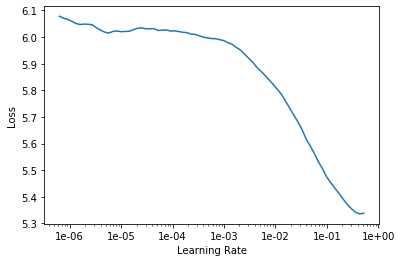

In [19]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

### Initial model training

Time to run:

* Full data set took about 13 hours using the Nvidia P1000
* Full data set was predicted to take about 25 hours with the T4
* 10% data took about 1 hour (1:08) using the Nvidia P1000
* 10% data is predicted to take about 2.5 hour (actual 2:42) using the Nvidia GTX 1060


In [25]:
release_mem()

In [26]:
# no idea how long nor how much resources this will take
# not sure 1e-2 is the right learning rate; maybe 1e-1 or between 1e-2 and 1e-1
# using t4
# progress bar says this will take around 24 hours... ran for about 52 minutes
# gpustat/nvidia-smi indicates currently only using about 5GB of GPU RAM
# using p100
# progress bar says this will take around 12 hours; took 13:16
# at start GPU using about 5GB RAM
# after about 8 hours GPU using about 7.5GB RAM.
# looks like I could increase batch size...
# with bs=64, still only seems to be using about 7GB GPU RAM after running for 15 minutes. 
# will check after a bit, but likely can increase batch size further

if os.path.isfile(init_model_file):
    learn.load(init_model_file)
    print('loaded learner')
else:
    learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))
    learn.save(init_model_file)
    print('generated new learner')

epoch,train_loss,valid_loss,accuracy,time
0,2.541368,2.339555,0.553032,2:42:26


generated new learner


In [ ]:
release_mem()

In [44]:
# continue from initial training - reload in case just want to continue processing from here
# pytorch automatically appends .pth to the filename, you cannot provide it
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load(init_model_file)
print('done')

done


In [42]:
learn.show_results()

text,target,pred
xxbos [ * * 2159 - 9 - 15 * * ] 2:53 xxup pm \n xxup chest (,xxup portable xxup ap ) xxmaj clip # [ * * xxmaj clip xxmaj number ( xxmaj radiology ) xxunk,xxup portable xxup ap ) xxmaj clip # [ * * xxmaj clip xxmaj number ( xxmaj radiology ) xxunk
restarted during her hospital \n stay . xxmaj she appeared to be fairly euvolemic . xxmaj she may \n,require xxmaj lasix to be restarted during her rehab stay . \n \n 1 . xxmaj heme :,have \n monday . be started . the stay . . xxmaj xxmaj . xxmaj she : xxmaj hct
pacing wire is seen in the xxup ra \n and extending into the xxup rv . \n \n,xxup left xxup ventricle : xxmaj mild symmetric xxup lvh . xxmaj moderately dilated xxup lv cavity . \n,xxup ventricle : xxmaj normal symmetric xxup lvh with xxmaj normal dilated xxup rv cavity . xxmaj xxmaj no global
* * ] 05:08 xxup am \n [ * * 2141 - 2 - 10 * * ] 05:26,xxup am \n [ * * 2141 - 2 - 10 * * ] 11:17 xxup am \n,xxup xxup am \n xxup * * xxmaj - 3 - 4 * * ] \n xxup pm
xxrep 78 _ \n xxup final xxup report \n xxup indication : 37-year - old woman with xxup,copd and increasing dyspnea on exertion in \n the setting of chest pain . xxmaj evaluate for pulmonary embolism,"hiv , xxup dyspnea . exertion . the the lower of \n pain . \n \n evaluate for"


In [20]:
prev_cycles = 0

if os.path.isfile(cycles_file):
    with open(cycles_file, 'rb') as f:
        prev_cycles = pickle.load(f)
print('This model has been trained for', prev_cycles, 'epochs already')

This model has been trained for 2 epochs already


### Now fine tune language model

Performance notes w/P100 GPU:

* at batch size of 128 takes about 1:14:00 per epoch; GPU usage is about 14GB; RAM usage is about 10GB
* at batch size of 96 takes about 1:17:00 per epoch; GPU usage is about  9GB; RAM usage is about 10GB
* at batch size of 48 takes about 1:30:00 per epoch; GPU usage is about  5GB; RAM usage is about 10GB

With `learn.fit_one_cycle(8, 5e-3, moms=(0.8,0.7))` (8 cycles)
* gets from about 62.7% accuracy to 67.6% accuracy
* Total time: 9:54:16

In [21]:
# if want to continue training existing model, set to True
# if want to start fresh from the initialized language model, set to False
# also, make sure to remove any previously created saved states before changing
# flag back to continue
continue_flag = True
########################################################
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

if continue_flag:
    file = lm_base_file + str(prev_cycles)
    learner_file = base_path/file
    if os.path.isfile(str(learner_file) + '.pth'):
        learn.load(learner_file)
        print('loaded existing learner from', str(learner_file))
    else:
        # should not continue as could not find specified file
        print('existing learner file not found')
        assert(False)
else:
    prev_cycles = 0

learn.unfreeze()

########################################################
# set this to how many additional cycles you want to run
########################################################
num_cycles = 2
########################################################

for n in range(num_cycles):
    #learn.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))
    print('    ', n + 1, 'addtional run of fit_one_cycle complete')
    file = lm_base_file + str(prev_cycles + n + 1)
    learner_file = base_path/file
    learn.save(learner_file)
    with open(cycles_file, 'wb') as f:
        pickle.dump(prev_cycles + n + 1, f)
    release_mem()
    
print('completed', num_cycles, 'new training epochs')
print('completed', num_cycles + prev_cycles, 'total training epochs')

loaded existing learner from /home/jupyter/mimic/mimic_lm_fine_tuned_2
     1 addtional run of fit_one_cycle complete
     2 addtional run of fit_one_cycle complete
completed 2 new training epochs
completed 4 total training epochs


epoch,train_loss,valid_loss,accuracy,time
0,1.926960,1.832659,0.627496,1:14:14
1,1.808083,1.755725,0.637424,1:14:15
2,1.747903,1.697741,0.645431,1:14:15
3,1.714081,1.652703,0.652703,1:14:19
4,1.637801,1.602961,0.660170,1:14:15
5,1.596906,1.553225,0.668557,1:14:14
6,1.572020,1.519172,0.674477,1:14:26
7,1.517364,1.510010,0.676342,1:14:14


In [24]:
fn_pattern = lm_base_file + '*'
training_files = glob.glob(str(base_path/fn_pattern))
training_files.sort()
training_files

['/home/jupyter/mimic/mimic_lm_fine_tuned_3.pth']

In [ ]:
# need to load the last file
learn.load(training_files[-1])

In [20]:
# test the language generation capabilities of this model (not the point, but is interesting)
TEXT = "For confirmation, she underwent CTA of the lung which was negative for pulmonary embolism"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

For confirmation, she underwent CTA of the lung which was negative for pulmonary embolism 
  but showed no PE , but did show some pulmonary edema . She has had 
  some mild dyspnea on exertion but has improved . She was brought to the 
  ED for further evaluation
For confirmation, she underwent CTA of the lung which was negative for pulmonary embolism or dissection . 
  She was extubated today and given 1 unit of prbcs for Hct of 24 . She is 
  afebrile , HR in the 120s , BP stable . She is


In [21]:
learn.save_encoder(enc_file)

To load the encoder:

```python
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load_encoder(enc_file)
```

## Now based on our language model, train a classifier

In [ ]:
class_file = 'mimic_cl.pickle'
filename = base_path/class_file

if os.path.isfile(filename):
    data_cl = load_data(base_path, file, bs=bs)
else:
    data_cl = (TextList.from_df(df, cols='', vocab=data_lm.vocab)
               #grab all the text files in path
               .split_by_folder(valid='test')
               #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
               .label_from_folder(classes=['neg', 'pos'])
               #label them all with their folders
               .databunch(bs=bs))

data_cl.save(filename)

In [28]:
df.head()

NameError: name 'df' is not defined

In [ ]:
data_cl.show_batch()

In [36]:
len(df.CATEGORY.unique())

15

In [37]:
len(df.DESCRIPTION.unique())

1676

In [ ]:
if os.path.isfile(filename):
    data_lm = load_data(base_path, file, bs=bs)
else:
    data_lm = (TextList.from_df(df, 'texts.csv', cols='TEXT')
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=0.1, seed=seed)
               #We randomly split and keep 10% for validation
               .label_from_df(cols='DESCRIPTION')
               #We want to do a language model so we label accordingly
               .databunch(bs=bs))
    data_lm.save(filename)

This is the version from the original example
```python
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')
```

In [ ]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(enc_file)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

Change learning rate based on results from the above plot

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))